<a href="https://colab.research.google.com/github/adindaayundra/PlantDiseaseClassification_Versi2/blob/main/PlantDiseaseClassification_MbkmRiset_Versi2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# **Implementation Plant Disease Classification Use Deep Learning** 
### by : Kurnia Adinda Ayundra Putri - 18.11.0173
---

>Goals : Projek ini dapat membangun sebuah model yang dapat mengklasifikasikan antara daun tanaman yang sehat dan yang tidak sehat dan juga jika tanaman tersebut memiliki penyakit, kita dapat memprediksi jenis penyakitnya.


#Library and Data Preparation

* Importing necessary libraries :  



In [1]:
!pip install kaggle
from google.colab import files

upload = files.upload()
for k in upload.keys():
  print(k)

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [48]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchsummary import summary
from torchvision import transforms

%matplotlib inline

*  Exploring the data :



In [3]:
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

100% 2.69G/2.70G [01:00<00:00, 60.1MB/s]
100% 2.70G/2.70G [01:00<00:00, 47.5MB/s]


In [4]:
!unzip -q /content/new-plant-diseases-dataset.zip

In [5]:
data_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
diseases = os.listdir(train_dir)

In [6]:
print(diseases)

['Tomato___Septoria_leaf_spot', 'Cherry_(including_sour)___Powdery_mildew', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Grape___healthy', 'Grape___Black_rot', 'Orange___Haunglongbing_(Citrus_greening)', 'Raspberry___healthy', 'Tomato___Tomato_mosaic_virus', 'Strawberry___Leaf_scorch', 'Pepper,_bell___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Bacterial_spot', 'Apple___healthy', 'Apple___Cedar_apple_rust', 'Potato___healthy', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Strawberry___healthy', 'Soybean___healthy', 'Peach___Bacterial_spot', 'Peach___healthy', 'Apple___Black_rot', 'Apple___Apple_scab', 'Tomato___Early_blight', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Tomato___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Pepper,_bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato___Leaf_Mold', 'Blueberry___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Esca_(Black_Measles)', 'Potato___Early_bligh

In [7]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 38


In [8]:
plants = []
num_diseases = 0

for plant in diseases:
  if plant.split('___')[0] not in plants:
    plants.append(plant.split('___')[0])
  if plant.split('___')[1] != 'healthy':
    num_diseases +=1

In [9]:
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Tomato', 'Cherry_(including_sour)', 'Grape', 'Orange', 'Raspberry', 'Strawberry', 'Pepper,_bell', 'Apple', 'Potato', 'Corn_(maize)', 'Soybean', 'Peach', 'Blueberry', 'Squash']


In [10]:
print("Number of plants: {}".format(len(plants)))

Number of plants: 14


In [11]:
print("Number of diseases: {}".format(num_diseases))

Number of diseases: 26


In [12]:
nums = {}
for position in diseases:
    nums[position] = len(os.listdir(train_dir + '/' + position))   

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=['Total Images']) 
img_per_class

Total Images
Tomato___Septoria_leaf_spot                                 1745
Cherry_(including_sour)___Powdery_mildew                    1683
Tomato___Late_blight                                        1851
Tomato___Target_Spot                                        1827
Grape___healthy                                             1692
Grape___Black_rot                                           1888
Orange___Haunglongbing_(Citrus_greening)                    2010
Raspberry___healthy                                         1781
Tomato___Tomato_mosaic_virus                                1790
Strawberry___Leaf_scorch                                    1774
Pepper,_bell___healthy                                      1988
Tomato___Spider_mites Two-spotted_spider_mite               1741
Tomato___Bacterial_spot                                     1702
Apple___healthy                                             2008
Apple___Cedar_apple_rust                                    1760
Potato___healthy                                            1824
Cherry_(including_sour)___healthy                           1826
Corn_(maize)___Common_rust_                                 1907
Strawberry___healthy                                        1824
Soybean___healthy                                           2022
Peach___Bacterial_spot                                      1838
Peach___healthy                                             1728
Apple___Black_rot                                           1987
Apple___Apple_scab                                          2016
Tomato___Early_blight                                       1920
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot          1642
Tomato___healthy                                            1926
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                  1722
Pepper,_bell___Bacterial_spot                               1913
Potato___Late_blight                                        1939
Tomato___Leaf_Mold                                          1882
Blueberry___healthy                                         1816
Corn_(maize)___Northern_Leaf_Blight                         1908
Grape___Esca_(Black_Measles)                                1920
Potato___Early_blight                                       1939
Squash___Powdery_mildew                                     1736
Tomato___Tomato_Yellow_Leaf_Curl_Virus                      1961
Corn_(maize)___healthy                                      1859

* Visualizing the above information on a graph :


Text(0.5, 1.0, 'Images per each class of plant disease')

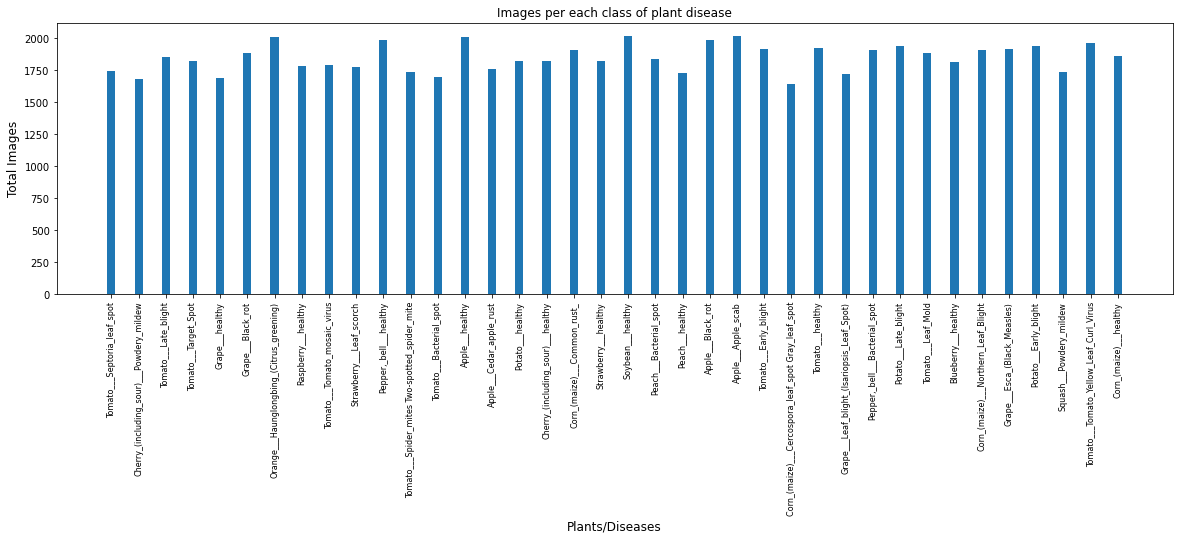

In [13]:
index = [a for a in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [a for a in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=12)
plt.ylabel('Total Images', fontsize=12)
plt.xticks(index, diseases, fontsize=8, rotation=90)
plt.title('Images per each class of plant disease')



*   Images available for training :


In [14]:
a_train = 0
for value in nums.values():
  a_train += value
print(f"There are {a_train} images for training")

There are 70295 images for training


# Data Preparation for Training

In [15]:
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(valid_dir, transform=transforms.ToTensor())

* Image Shape :

In [16]:
img, label = train [0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [17]:
len(train.classes)

38

In [18]:
def show_image(image, label):
  print("Label :" + train.classes[label] + "(" + str(label) + ")")

  plt.imshow(image.permute(1, 2, 0))

# Some Images from training dataset

Label :Apple___Apple_scab(0)


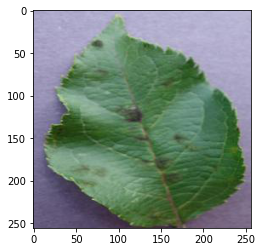

In [19]:
show_image(*train[0])

Label :Tomato___healthy(37)


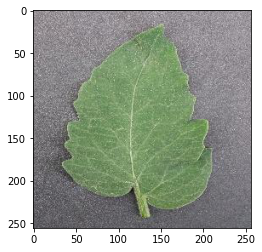

In [20]:
show_image(*train[70000])

Label :Blueberry___healthy(4)


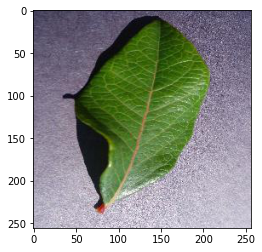

In [21]:
show_image(*train[9000])

Label :Corn_(maize)___Common_rust_(8)


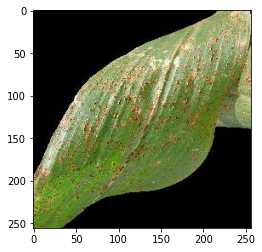

In [22]:
show_image(*train[15000])

In [23]:
random_seed = 8
torch.manual_seed(random_seed)

In [24]:
batch_size = 32

In [25]:
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)

valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [26]:
def show_batch(data):
  for images, labels in data:
    fig, ax = plt.subplots(figsize=(30, 30))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
    break

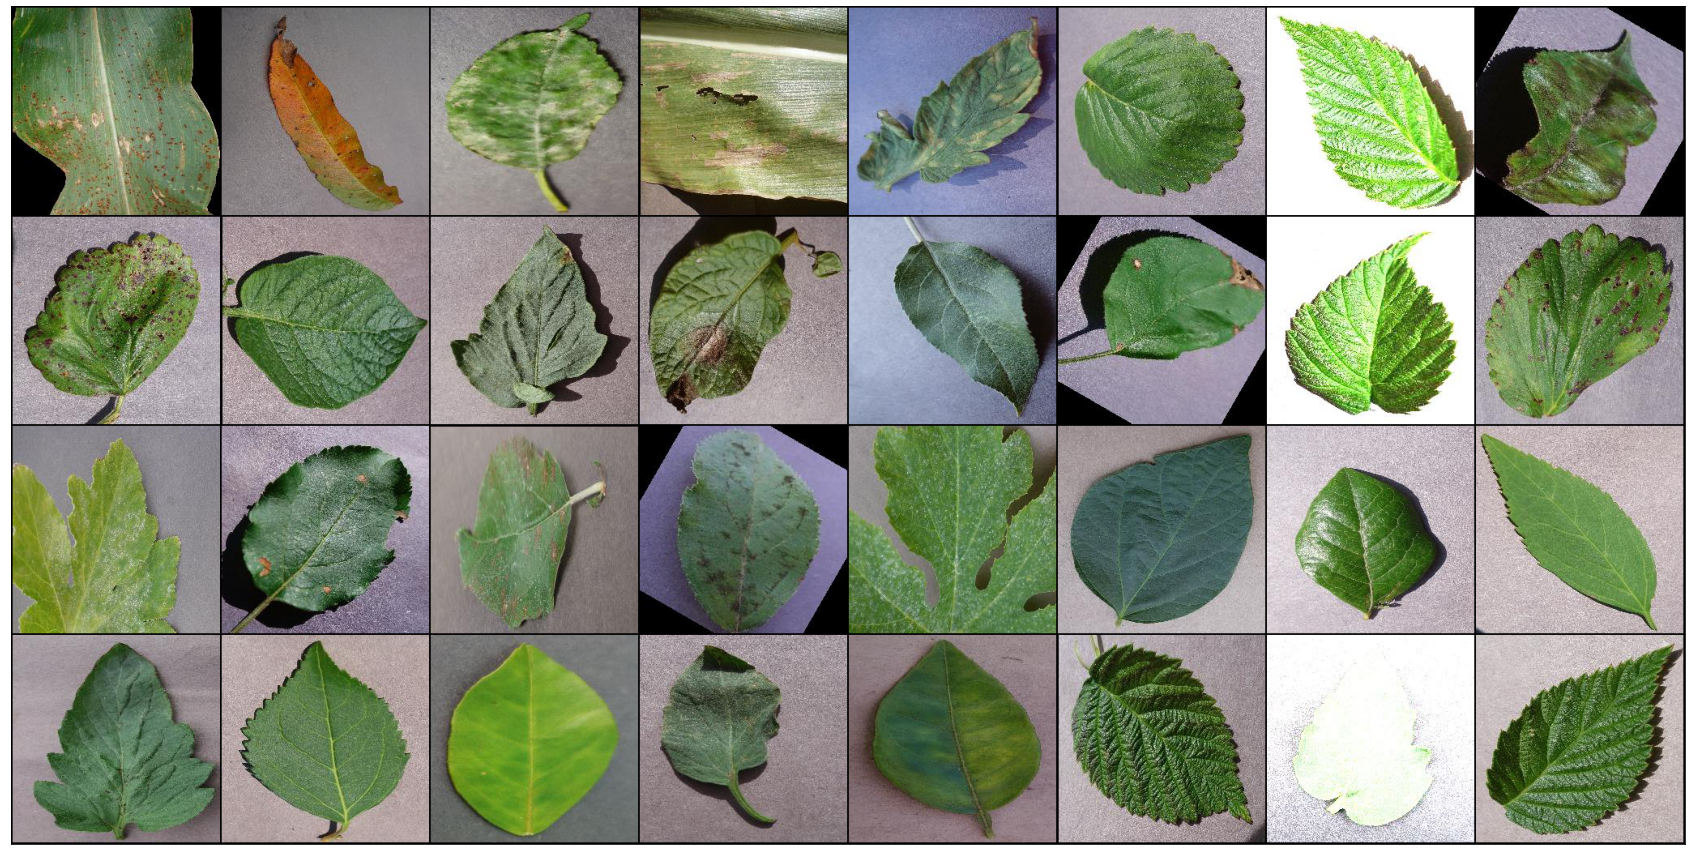

In [27]:
show_batch(train_dl)

# Modelling

* Some helper functions   

In [28]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)


*   Checking the device we are working with :

In [29]:
device = get_default_device()
device

device(type='cuda')

*   Moving data into GPU

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

# Building the Model Architecture

*   Residual Block Code Implementation :

In [31]:
class SimpleResidualBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(out)
    return self.relu2(out) + x

In [32]:
# code buat kalkulasi akurasi: 
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# base class for the model
class ImageClassificationBase(nn.Module):

  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {"val_loss": loss.detach(), "val_accuracy": acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x["val_loss"] for x in outputs]
    batch_accuracy = [x["val_accuracy"] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    epoch_accuracy = torch.stack(batch_accuracy).mean()
    return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

# Defining the Final Architecture of our Model

In [33]:
# Architecture for Training
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)


# ResNet Architecture 
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()
        
        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64 
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))
        
        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))
        
    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [34]:
model = to_device(ResNet9(3, len(train.classes)), device) 
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [35]:
# getting summary of the model
INPUT_SHAPE = (3, 256, 256)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4        [-1, 128, 256, 256]          73,856
       BatchNorm2d-5        [-1, 128, 256, 256]             256
              ReLU-6        [-1, 128, 256, 256]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training the Model

In [36]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()
            
    
        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

In [37]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 2min 42s, sys: 4.18 s, total: 2min 46s
Wall time: 2min 43s


In [38]:
epochs = 2
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [42]:
# time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                            grad_clip=grad_clip,
                            weight_decay=1e-4,
                            opt_func=opt_func)

Epoch [0], last_lr: 0.00812, train_loss: 0.5438, val_loss: 0.5032, val_acc: 0.8369
Epoch [1], last_lr: 0.00000, train_loss: 0.1267, val_loss: 0.0296, val_acc: 0.9911


# Plotting

In [43]:
def plot_accuracies(history):
  accuracies = [x['val_accuracy'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.plot(lrs)
  plt.xlabel('Batch no.')
  plt.ylabel('Learning rate')
  plt.title('Learning Rate vs. Batch no.');

# Validation Accuracy

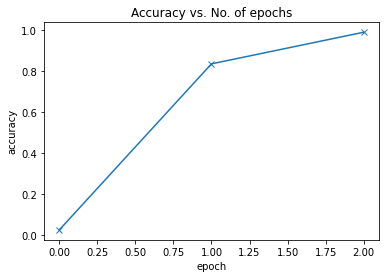

In [44]:
plot_accuracies(history)

# Validation Loss

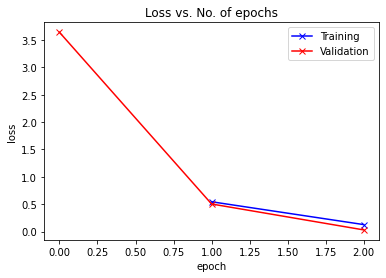

In [45]:
plot_losses(history)

# Learning Rate Overtime

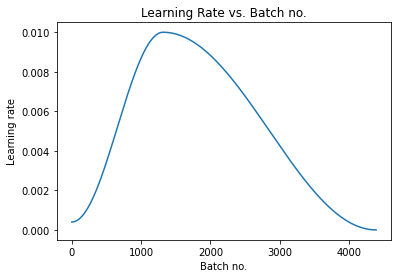

In [46]:
plot_lrs(history)

# Testing Model on Test Data

In [68]:
test = ImageFolder(data_dir, transform=transforms.ToTensor())
os.listdir(data_dir + "/../../new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)")

['train']

In [67]:
test_dir = "../input/new-plant-diseases-dataset/test"
test = ImageFolder(test_dir, transform=transforms.ToTensor())

FileNotFoundError: ignored

In [ ]:
def predict_image(img, model):
    

    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)

    # Get predictions from model
    yb = model(xb)

    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)

    # Retrieve the class label

    return train.classes[preds[0].item()]

In [ ]:
# predicting first image

img, label = test[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_images[0], ',Predicted:', predict_image(img, model))

In [ ]:
# getting all predictions

for i, (img, label) in enumerate(test):
  print('Label:', test_images[i], ', Predicted:', predict_image(img, model))

# Saving the Model

In [ ]:
# saving to the kaggle working directory
PATH = './plant-disease-model.pth'
torch.save(model.state_dict(), PATH)